## Neural Network and Convolutional Neural Network Practice

Self taught deep learning using book "Deep Learning" published by O'Reilly.

The basic structure of neural network is cell. The cell takes input and generate output based on the input value. Similar to $y = f(x)$. $x$ is the input value, $f(x)$ is the internal function, and $y$ is the output value.

In [1]:
# import necessary package
import numpy as np

In [2]:
# basic notes for np array
x = np.array([[2,3,4],[5,6,7]])
print(x)
print('Use .shape to check x size: ' + str(x.shape))
print('Use .ndim to check x dimension: '+ str(x.ndim))

[[2 3 4]
 [5 6 7]]
Use .shape to check x size: (2, 3)
Use .ndim to check x dimension: 2


### Helper functions

Step function is not a good choice for activating cells in practical due to the sharp step at 0. The cell input values are usually processed by **Sigmoid** or **Relu** functions to create a smooth version input. For regression, the final results are directly used. For classification problem, **Softmax** function is commonly used to choice final selection.

In [3]:
# single function version for Two Layer Case
# y = 1/(1+exp(-x))
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x) )

# ReLU
# y = x if x>0 else 0
def relu(x):
    return np.maximum(0, x)

# gradient of sigmoid function
def sigmoid_grad(x):
    return ( 1.0 - sigmoid(x) ) * sigmoid(x)

# gradient of relu function
def relu_grad(x):
    grad = np.zeros(x)
    grad[x>0] = 1
    return grad

# softmax function, usually used for clasification problem
# yk = exp(ak) / sum(exp(ai))
# the results can be treat as probability
def softmax(x):
    # following code will fail if the number is too large 
    # overflow caused by exp calculation
    # return np.exp(x) / np.sum(exp_x)
    
    # substract max of x before exp calculation to prevent overflow
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

### Loss function
For all machine learning problems, we need a loss function to help our model learning (adjusting weights). Both mean square error function and cross entropy error function are commonly used in neural network. 

The cross entropy error function can be expressed as:

$E = - \sum t_k\log y_k$

In [4]:
# error functions
# mse
def mse(y_h, y):
    return 0.5 * np.sum( (y_h-y)**2 )

# cross entropy error 1d version
def cross_entropy_error(y_h, y):
    delta = 1e-7 # prevent log function error
    return -np.sum( y * np.log(y_h+delta) )

### Practice 1: 1 layer network

First we build a simple 1 layer network with 3 cells can take 2 input values and can predict 3 different classes.

In [10]:
# simple net practice
class simpleNet:
    def __init__(self):
        # [x1, x2] * [W11 W12 W13] + [b1 b2 b3].T -> softmax -> [y1 y2 y3].T
        #            [w21 w22 W23]
        self.W = np.random.randn(2,3)
    
    def predict(self, x):
        return softmax(np.dot(x,self.W))
    
    def loss(self, x, y):
        y_h = softmax(self.predict(x))
        return cross_entropy_error(y_h, y)

In [21]:
# initiate simple network
net = simpleNet()

# given inputs x1, x2 = 0.6, 0.9
x = np.array([0.6, 0.9])

# predict y
y_hat = net.predict(x)
print('Prediction: ' + str(y_hat))

# assume actual result is [0, 0, 1]
t =np.array([0, 0, 1])

# cross entropy error
error = net.loss(x, t)
print('Cross Entropy Error: ' + str(error))

Prediction: [0.08924877 0.27614994 0.63460129]
Cross Entropy Error: 0.8234710325675663


### Practice 2: 2 layers network

Second, build a simple 2 layers network with 100 cells. The input and output size are dynamic. The initial weights are set using random function.

In [51]:
# Some helper functions need to modify for high dimension calculation
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0) # axis = 0: vertical 
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

# for one-hot-encoding label
def cross_entropy_error(y, t):
    delta = 1e-7
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y+delta)) / batch_size

In [44]:
# 2 layers
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        
        # 1st layer size: from input to cell size
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        
        # 2nd layer size: from cell size to output size
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        # first layer: input * W1 + b1
        l1 = np.dot(x, self.params['W1']) +  self.params['b1']
        # use sigmoid function to smooth values
        z1 = sigmoid(l1)
        
        # second layer: input * W2 + b2
        l2 = np.dot(z1, self.params['W2']) + self.params['b2']
        # use softmax to normalize the result
        y_h = softmax(l2)
        
        return y_h
    
    def error(self, x, y):
        y_h = self.predict(x)
        return cross_entropy_error(y_h, y)
    
    def accuracy(self, x, y):
        y_h = self.predict(x)
        # extract highest probability index, same as digit
        y_h = np.argmax(y_h, axis = 1)
        # convert one_hat_encode label back to digit
        y = np.argmax(y, axis = 1)
        # return correct # / total #
        return np.sum(y_h == y) / float(x.shape[0])
    
    # numerical gradient
    # the purpose showing numerical gradient function is 
    # to show how slow the method is.
    # graph gradient method is much faster.
    def numerical_gradient(self, x, y):
        pass
        #loss_W = lambda W: self.loss(x, t)
        #grads = {}
        #grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        #grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        #grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        #grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        #return grads
    
    # graph gradient
    def gradient(self, x, y):
        grads = {}
        
        batch_num = x.shape[0] # number of data used
        
        # forward
        l1 = np.dot(x, self.params['W1']) + self.params['b1']
        z1 = sigmoid(l1)
        l2 = np.dot(z1, self.params['W2']) + self.params['b2']
        y_h = softmax(l2)
        
        # backward
        dy = (y_h-y) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis = 0)
        
        dz1 = np.dot(dy, self.params['W2'].T)
        dl1 = sigmoid_grad(l1) * dz1
        grads['W1'] = np.dot(x.T, dl1)
        grads['b1'] = np.sum(dl1, axis = 0)
        
        return grads

In [79]:
# initiate two layers network with input size 784 (equals to 28*28 image size), 
# hidden layer with 100 cells, and output size 10 as 0~9 digits.
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size= 10)

# show the matrix size
print('Size of input * 1st layer cells: ' + str(net.params['W1'].shape))
print('Size of 1st layer bias vecotr: ' + str(net.params['b1'].shape))
print('Size of input * 1st layer cells: ' +str(net.params['W2'].shape))
print('Size of 2nd layer bias vecotr: ' + str(net.params['b2'].shape))

# random assign value of 100 pics (28*28 pixel)
# size will be 100 pics * 784 pixel, means each row is a data point
x = np.random.rand(100,784)

# prediction
y = net.predict(x)

# random assign labels
t = np.random.rand(100, 10)

Size of input * 1st layer cells: (784, 100)
Size of 1st layer bias vecotr: (100,)
Size of input * 1st layer cells: (100, 10)
Size of 2nd layer bias vecotr: (10,)


An important concept here is to understand how to use computational graph to estimate the gradient. The method is way faster than numerical gradient method.

### Apply 2 layers model to train and test MNIST data

In [53]:
import os
from mnist import MNIST
mnidata = MNIST(os.getcwd()+'/Data')
train_img, train_lab = mnidata.load_training()
test_img, test_lab = mnidata.load_testing()

In [54]:
train_data = np.array(train_img)
train_label = np.array(train_lab)
test_data = np.array(test_img)
test_label = np.array(test_lab)

# normalize image
train_data = train_data.astype(np.float32)
train_data /= 255.0
test_data = test_data.astype(np.float32)
test_data /= 255.0

# convert label to one hot encoding
def one_hot_encoding(labels, num_of_classes):
    res = np.eye(num_of_classes)[np.array(labels).reshape(-1)]
    return res.reshape(list(labels.shape)+[num_of_classes])

train_label = one_hot_encoding(train_label, 10)
test_label = one_hot_encoding(test_label, 10)

In [55]:
# apply mnist data, using 100 cells per layer
network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [80]:
# parameters
iteration_number = 10000
train_data_size = train_data.shape[0]
batch_data_size = 100
learning_rate = 0.1

train_error_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = train_data_size/batch_data_size

print('Training data size: ' + str(train_data.shape[0]))
print('Testing data size: ' + str(test_data.shape[0]))
print('1 epoch needs '+ str(iter_per_epoch)[:-2] + ' iteration' )
print('Note: epoch equals to size of training data')

Training data size: 60000
Testing data size: 10000
1 epoch needs 600 iteration
Note: epoch equals to size of training data


In [81]:
# training
for i in range(iteration_number):
    # mini-batch, using random function to randomly choicing data
    batch_selection = np.random.choice(train_data_size, batch_data_size)
    traing_data_batch = train_data[batch_selection]
    train_label_batch = train_label[batch_selection]
    
    # compute gradient
    grads = network.gradient(traing_data_batch, train_label_batch)
    
    # update weights
    # New Weights = Weights - learning_rate * Weights gradients
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grads[key]
        
    # record error
    error = network.error(traing_data_batch, train_label_batch)
    train_error_list.append(error)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(train_data, train_label)
        test_acc = network.accuracy(test_data, test_label)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("---- " + str(i//iter_per_epoch)[:-2] +" epoch" "----" )
        print("Training set accuracy: " + str(train_acc))
        print("Testing set accuracy: " + str(test_acc))

---- 0 epoch----
Training set accuracy: 0.93095
Testing set accuracy: 0.9318
---- 1 epoch----
Training set accuracy: 0.9347666666666666
Testing set accuracy: 0.9349
---- 2 epoch----
Training set accuracy: 0.9381666666666667
Testing set accuracy: 0.9373
---- 3 epoch----
Training set accuracy: 0.9405833333333333
Testing set accuracy: 0.9388
---- 4 epoch----
Training set accuracy: 0.9424166666666667
Testing set accuracy: 0.9413
---- 5 epoch----
Training set accuracy: 0.945
Testing set accuracy: 0.9434
---- 6 epoch----
Training set accuracy: 0.94635
Testing set accuracy: 0.9443
---- 7 epoch----
Training set accuracy: 0.9475666666666667
Testing set accuracy: 0.946
---- 8 epoch----
Training set accuracy: 0.9493166666666667
Testing set accuracy: 0.9468
---- 9 epoch----
Training set accuracy: 0.951
Testing set accuracy: 0.9489
---- 10 epoch----
Training set accuracy: 0.9520833333333333
Testing set accuracy: 0.9501
---- 11 epoch----
Training set accuracy: 0.9534666666666667
Testing set accuracy

In [58]:
from matplotlib import pyplot as plt
import seaborn as sns

In [59]:
def squareFormat(x):
    square = np.array(x)
    square.resize(28,28)
    return square
    
def showImg(x,label):
    plt.imshow(x, cmap = 'gray')
    plt.title('Predicted digit: '+ str(label))
    plt.xticks([])
    plt.yticks([])

In [85]:
y_h = network.predict(test_data)
y_h = np.argmax(y_h, axis = 1)
y = np.argmax(test_label, axis = 1)

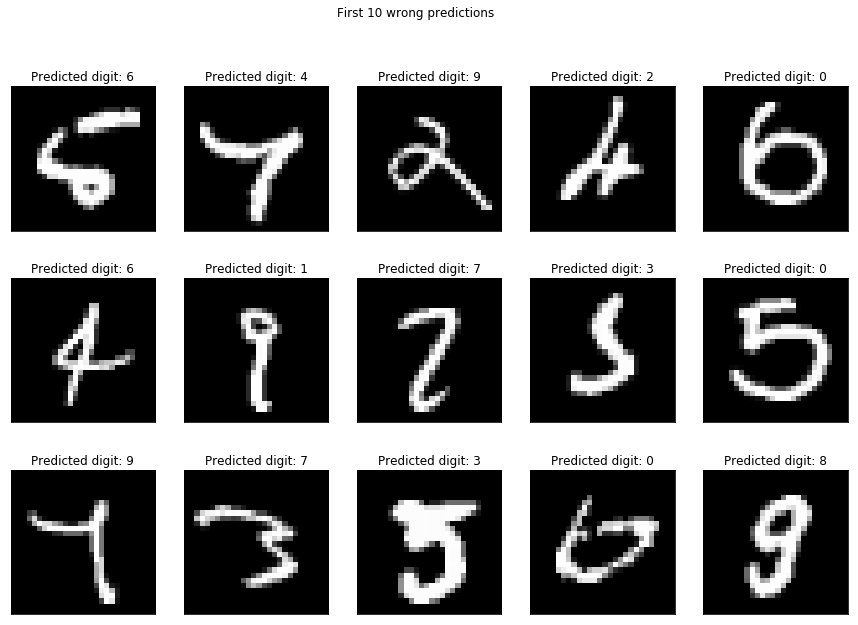

In [86]:
img = test_data[y_h!=y][0:15]
pre = y_h[y_h!=y][0:15]

fig = plt.figure(figsize = (15,10))
_ = fig.suptitle('First 10 wrong predictions')
for i in range(1,16):
    plt.subplot(3,5,i)
    showImg(squareFormat(img[i-1]), pre[i-1])